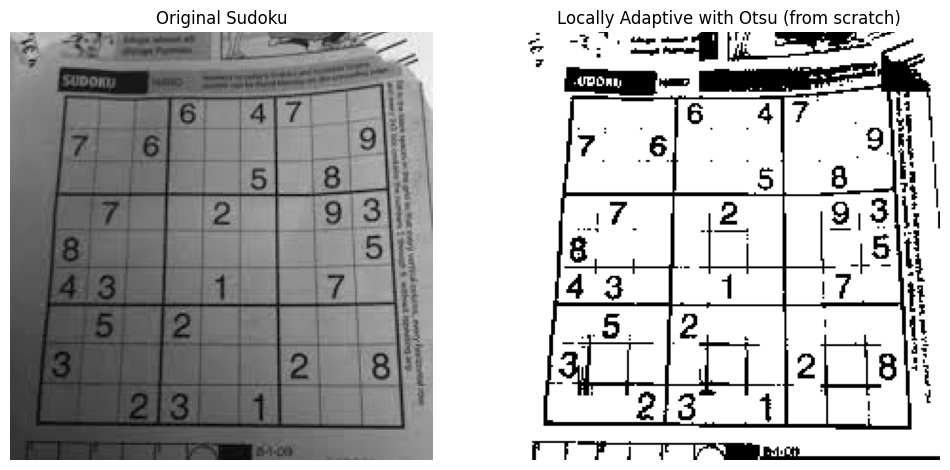

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def otsu_threshold(image):
    """
    Pure Python Otsu implementation (based on between-class variance).
    Input: grayscale image (uint8)
    Output: threshold value
    """
    # Histogram
    hist, bins = np.histogram(image.ravel(), bins=256, range=(0, 256))
    total = image.size
    
    # Normalize histogram
    prob = hist / total
    
    # Cumulative sums
    omega = np.cumsum(prob)           # class probabilities
    mu = np.cumsum(prob * np.arange(256))  # class means
    
    # Global mean
    mu_total = mu[-1]
    
    # Between-class variance
    sigma_b_squared = (mu_total * omega - mu)**2 / (omega * (1 - omega) + 1e-6)
    
    # Best threshold = argmax sigma_b_squared
    T = np.argmax(sigma_b_squared)
    return T


def locally_adaptive_threshold(img, window_size=32, var_threshold=500):
    h, w = img.shape
    out = np.zeros_like(img, dtype=np.uint8)

    for y in range(0, h, window_size):
        for x in range(0, w, window_size):
            y_end = min(y + window_size, h)
            x_end = min(x + window_size, w)
            window = img[y:y_end, x:x_end]

            variance = np.var(window)
            threshold = otsu_threshold(window)

            if variance < threshold:
                mean_val = np.mean(window)
                out[y:y_end, x:x_end] = 255 if mean_val > 127 else 0
            else:
                # Apply Otsu from scratch
                T = otsu_threshold(window)
                _, local_thresh = cv2.threshold(window, T, 255, cv2.THRESH_BINARY)
                out[y:y_end, x:x_end] = local_thresh

    return out


# === Load Sudoku image ===
img = cv2.imread("sudoku2.png", cv2.IMREAD_GRAYSCALE)

# Apply adaptive thresholding
result = locally_adaptive_threshold(img, window_size=32, var_threshold=300)

# Show result
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original Sudoku")
plt.imshow(img, cmap='gray')
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Locally Adaptive with Otsu (from scratch)")
plt.imshow(result, cmap='gray')
plt.axis("off")
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_mser_regions(gray, delta=5, min_area=60, max_area=14400, max_variation=0.25):
    """
    Detect MSER regions in a grayscale image using OpenCV MSER.
    Returns:
      - regions: list of contours (each contour: Nx2 array of points)
      - bboxes: list of bounding boxes for each region (x,y,w,h)
    Key parameters:
      - delta: step between intensity thresholds (larger -> fewer regions)
      - min_area / max_area: filter by area
      - max_variation: allowed variation to consider region stable
    """
    # Create MSER detector with chosen parameters
    mser = cv2.MSER_create(_delta=delta,
                          _min_area=min_area,
                          _max_area=max_area,
                          _max_variation=max_variation)
    regions, _ = mser.detectRegions(gray)  # regions: list of point lists

    # Convert to contours (numpy arrays) and compute bboxes
    contours = []
    bboxes = []
    for reg in regions:
        pts = np.array(reg).reshape(-1, 2)
        # approximate hull to make a nicer contour
        hull = cv2.convexHull(pts)
        contours.append(hull)
        x, y, w, h = cv2.boundingRect(hull)
        bboxes.append((x, y, w, h))
    return contours, bboxes

def draw_contours_overlay(img_bgr, contours, color=(0,0,255), thickness=1):
    """
    Draw contours (hulls) onto a copy of the image and return it.
    color in BGR.
    """
    out = img_bgr.copy()
    cv2.drawContours(out, contours, -1, color, thickness)
    return out

def regions_to_mask(shape, contours):
    """
    Build a binary mask (uint8) from list of contours/hulls.
    """
    mask = np.zeros(shape, dtype=np.uint8)
    cv2.fillPoly(mask, pts=contours, color=255)
    return mask

# === Main routine ===
if __name__ == "__main__":
    # Load image (grayscale & color copy)
    img_path = ".png"
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)

    if img_gray is None:
        raise FileNotFoundError(f"Can't load image: {img_path}")

    # --- Detect bright MSERs (objects that are brighter than surroundings) ---
    contours_bright, bboxes_bright = detect_mser_regions(
        img_gray,
        delta=5,
        min_area=30,
        max_area=5000,
        max_variation=0.25
    )

    # --- Detect dark MSERs by inverting intensity (dark regions become bright) ---
    img_inv = 255 - img_gray
    contours_dark, bboxes_dark = detect_mser_regions(
        img_inv,
        delta=5,
        min_area=30,
        max_area=5000,
        max_variation=0.25
    )

    # --- Visualize (overlay bright=red, dark=green contours) ---
    overlay = img_bgr.copy()
    # red for bright
    overlay = draw_contours_overlay(overlay, contours_bright, color=(0,0,255), thickness=1)
    # green for dark
    overlay = draw_contours_overlay(overlay, contours_dark, color=(0,255,0), thickness=1)

    # Build masks
    mask_bright = regions_to_mask(img_gray.shape, contours_bright)
    mask_dark = regions_to_mask(img_gray.shape, contours_dark)
    # Combined mask
    mask_combined = cv2.bitwise_or(mask_bright, mask_dark)

    # Optional: clean up mask with morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask_clean = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel, iterations=1)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=1)

    # Create visualization for mask: overlay red tint for MSER regions
    colored = img_bgr.copy()
    red_tint = np.zeros_like(colored)
    red_tint[:,:,2] = 255
    alpha = 0.5
    colored[mask_clean==255] = cv2.addWeighted(colored, 1-alpha, red_tint, alpha, 0)[mask_clean==255]

    # Show results with matplotlib (convert BGR->RGB)
    def bgr2rgb(img): return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(14,8))
    plt.subplot(2,3,1)
    plt.title("Original (gray)")
    plt.imshow(img_gray, cmap='gray')
    plt.axis('off')

    plt.subplot(2,3,2)
    plt.title("MSER overlay (red=bright, green=dark)")
    plt.imshow(bgr2rgb(overlay))
    plt.axis('off')

    plt.subplot(2,3,3)
    plt.title("Mask (bright regions)")
    plt.imshow(mask_bright, cmap='gray')
    plt.axis('off')

    plt.subplot(2,3,4)
    plt.title("Mask (dark regions)")
    plt.imshow(mask_dark, cmap='gray')
    plt.axis('off')

    plt.subplot(2,3,5)
    plt.title("Combined mask (cleaned)")
    plt.imshow(mask_clean, cmap='gray')
    plt.axis('off')

    plt.subplot(2,3,6)
    plt.title("Colored overlay (MSER regions highlighted)")
    plt.imshow(bgr2rgb(colored))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # --- Optionally save outputs ---
    cv2.imwrite("/mnt/data/mser_overlay.png", overlay)
    cv2.imwrite("/mnt/data/mser_mask.png", mask_clean)
    cv2.imwrite("/mnt/data/mser_colored.png", colored)

    print("Saved: /mnt/data/mser_overlay.png, /mnt/data/mser_mask.png, /mnt/data
